In [1]:
import cv2
import subprocess
import re
import numpy as np
import pandas as pd
from PyPDF2 import PdfFileReader
from IPython.display import Image
from collections import Counter
import matplotlib.pyplot as plt
from itertools import groupby

In [2]:
%matplotlib inline

### PDF to CSV Block Based Algorithm

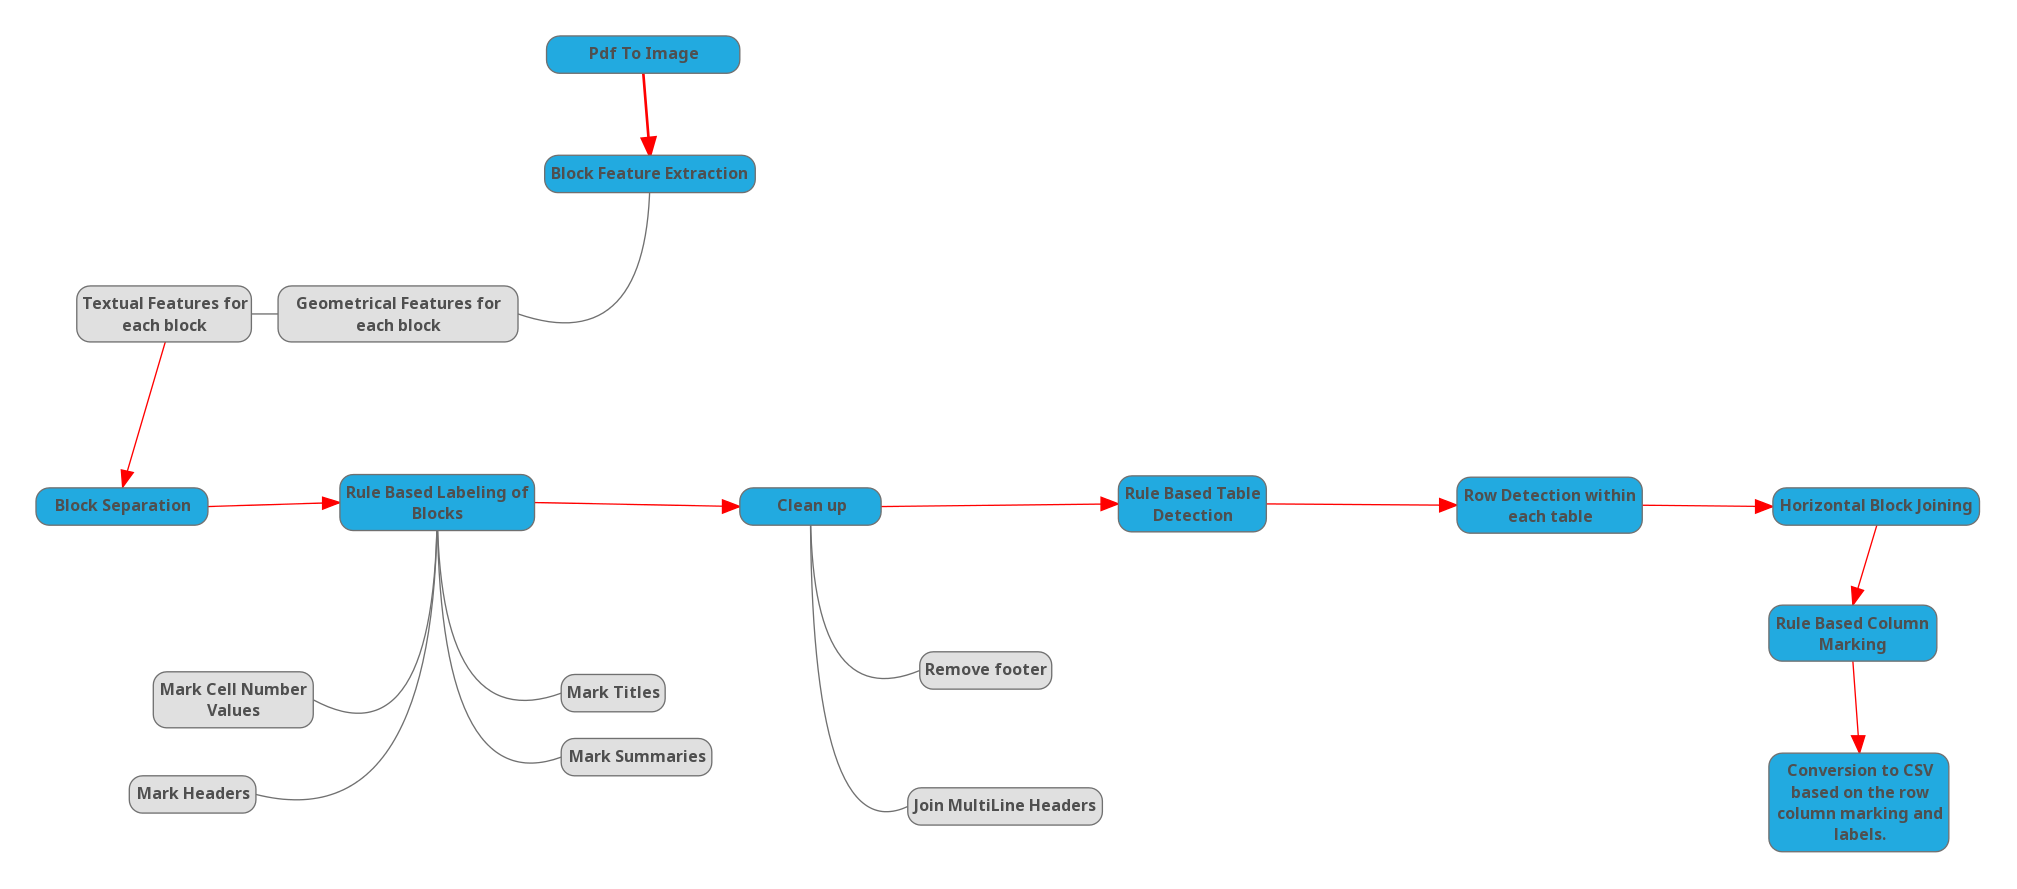

In [3]:
Image(filename='block_pdf_img_to_csv.png')

The Algorithm is a mix of Feature engineering/extraction and rule based labeling of blocks, where blocks are defined as group of texts separated by whitespace.

The first step to the algorithm is Block generation itself. We use an algorithm called [Run Length Smoothing Algorithm (RLSA)](#RLSA). 




After getting the blocks with generate two kinds of features : 

    - Geometrical features using `connectedComponentsWithStats` from [OpenCV](http://opencv.org/).
      This gives us features like: 
        - Left most point
        - Top most point
        - Height
        - Width etc.
    - Text Based Features, the text within each block is extracted using pdftotext from `poppler-0.57.0`
      https://poppler.freedesktop.org/. Using the text we generate textual features like:
        - Text Length
        - "is_text", defining whether the block contains numbers or text only.
        - "possible_row_merger", we detect if there is a possibilty of rows being merged in a block. 
          Its easily detected if the text has the new like character `\n`
        and more.
        

In [4]:
# Lets Load an image first.

def get_page_image_from_pdf(pdf, page_num, image_file_name):
    page_layout = pdf.getPage(page_num)['/MediaBox']
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)

def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')

def plot_horizontal_lines(line_ys, img, x_start, x_end):
    waste_copy2 = img.copy()
    for line_y in line_ys:
        line_starting_points = (int(x_start), int(line_y))
        line_stopping_points = (int(x_end), int(line_y))
        cv2.line(waste_copy2, line_starting_points, line_stopping_points, (125,255,0), 3)
    plot_page(waste_copy2)

def plot_vertical_lines(line_xs, img, y_start, y_end):
    waste_copy2 = img.copy()
    for line_x in line_xs:
        line_starting_points = (line_x, y_start)
        line_stopping_points = (line_x, y_end)
        cv2.line(waste_copy2, line_starting_points, line_stopping_points, (125,255,0), 3)
    plot_page(waste_copy2)
    
pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'
pdf = PdfFileReader(open(pdf_file_path, 'rb'))
page_layout = pdf.getPage(3)['/MediaBox']
if '/Rotate' in pdf.getPage(3) and pdf.getPage(3)['/Rotate'] == 90:
    page_width = float(page_layout[3])
    page_height = float(page_layout[2])
else:
    page_width = float(page_layout[2])
    page_height = float(page_layout[3])
img_page = get_page_image_from_pdf(pdf, 2, 'west_bengal_demand_1_5_page_1.png')
image_height, image_width = img_page.shape
horizontal_ratio = page_width / image_width
vertical_ratio = page_height / image_height


In [5]:
class ImageToBlocks(object):
    '''Convert Images to images with block like structures.
    
    Args:
        - img (obj:`numpy.Array`): A numpy array of the image.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertical and horizontal for block generation.
    '''
    def __init__(self, img, block_threshold):
        self.img = img
        self.block_threshold = block_threshold
    
    def generate_blocks(self):
        ret,thresh1 = cv2.threshold(self.img, 0, 1, cv2.THRESH_BINARY_INV)
        img_iter = np.nditer(thresh1, flags=['multi_index'])
        C_vertical, C_horizontal = self.block_threshold
        temp_thresh = thresh1.copy()
        while not img_iter.finished:
            x, y = img_iter.multi_index
            x_threshold = x + C_horizontal
            y_threshold = y + C_vertical
            neg_x_threshold = x - C_horizontal
            neg_y_threshold = y - C_vertical
            if (thresh1[x:x_threshold, y:y_threshold].any() 
                or thresh1[x:x_threshold, y:neg_y_threshold].any()
                or thresh1[x:neg_x_threshold, y:y_threshold].any()
                or thresh1[x:neg_x_threshold, y:neg_y_threshold].any()):
                temp_thresh[x, y] = 1
            else:
                temp_thresh[x, y] = 0
            img_iter.iternext()
        return temp_thresh
    
    def generate_blocks_dilation(self):
        kernel = np.ones((5,10),np.uint8)
        ret,thresh1 = cv2.threshold(self.img, 0, 1, cv2.THRESH_BINARY_INV)
        return cv2.dilate(thresh1,kernel,iterations = 5)

    
class BlockGeometricalFeatureGenerator(ImageToBlocks):
    '''Extract geometrical feature for each block in a dataframe.
    
    Args:
        - img (obj:`numpy.Array`): A numpy array of the image.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertgenerical and horizontal for block generation.
    '''
    def __init__(self, img, block_threshold, dilate=False):
        self.dilate = dilate
        super(BlockGeometricalFeatureGenerator, self).__init__(img, block_threshold)
        
    @staticmethod
    def __get_block_stats_df(stats, centroids):
        '''Convert stats from cv2.connectedComponentsWithStats to dataframe.
        
        Args:
            - stats (obj:`numpy.Array`): the stats generated from openCV
        
        Returns:
            A dataframe with stats
        '''
        stats_columns = ["left", "top", "width", "height", "area"]
        block_stats = pd.DataFrame(stats, columns=stats_columns)
        block_stats['centroid_x'], block_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
        # Ignore the label 0 since it is the background
        block_stats.drop(0, inplace=True)
        return block_stats
    
    def extract_block_stats(self):
        '''Extract Geometrical features from img with blocks.
        
        Returns:
            A dataframe with each row as block and its geom features.
        '''
        if self.dilate:
            self.img_with_blocks = self.generate_blocks_dilation()
        else:
            self.img_with_blocks = self.generate_blocks()
        _, _, stats, centroids = cv2.connectedComponentsWithStats(self.img_with_blocks)
        block_stats = self.__get_block_stats_df(stats, centroids)
        block_stats['right'] = block_stats.left + block_stats.width
        block_stats['bottom'] = block_stats.top + block_stats.height
        block_stats['pos'] = block_stats.index
        return block_stats
    
    @staticmethod
    def overlay_img_with_blocks(img, blocks):
        raise NotImplementedError('To be Implemented in Version 0.2')


class BlockTextualFeatureGenerator(BlockGeometricalFeatureGenerator):
    '''Extract Textual Features of each block.
    
    Args:
        - img (obj:`numpy.Array`): Matrix form of the image.
        - horizontal_ratio (float): ratio of page_width and image_width.
        - vertical_ratio (float): ratio of page_height and image_height.
        - page_num (int): Page number from where to read the text.
        - pdf_file_path (string): Path of the pdf file.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertical and horizontal for block generation.
        - post_processors (list:[functions]): A list of functions that can process
            the blocks generated.
    '''
    TEXT_REGEX = '[a-zA-Z_]+'
    COMMA_SEP_REGEX = '^(-|[1-9])[0-9]*(,[0-9]).*$'
    
    def __init__(self, img, horizontal_ratio,
                 vertical_ratio, page_num, 
                 pdf_file_path, block_threshold,
                 post_processors=[],
                 dilate=False):
        #image params
        self.img = img
        self.block_threshold = block_threshold
        # these are required for scaling boundaries while reading text.
        self.horizontal_ratio = horizontal_ratio
        self.vertical_ratio = vertical_ratio
        # since we use an external command to extract text we need 
        # to have some pdf information also.
        self.pdf_file_path = pdf_file_path
        self.page_num = page_num
        # post processors
        self.post_processors = post_processors
        self.dilate = dilate
    
    @staticmethod
    def check_text_for_continous_dashes(text):
        for char, count in [[k, len(list(g))] for k, g in groupby(text)]:
            if char == '-' and count > 2:
                return True
        return False
    
    def get_text_from_pdf(self, x, y, w, h):
        cmd_ext = 'pdftotext'
        cmd_page_params = ' -f {0} -l {0}'.format(self.page_num + 1)
        cmd_tail = ' -x {0} -y {1} -W {2} -H {3} "{4}" -'.format(int(x), 
                                                                 int(y),
                                                                 int(w),
                                                                 int(h),
                                                                 self.pdf_file_path)
        command = cmd_ext + cmd_page_params + cmd_tail
        return subprocess.check_output(command, shell=True)
    
    def generate_text_data(self, row):
        '''Generate Text features for a given block.
        '''
        x = (row['left'] * self.horizontal_ratio)
        y = (row['top'] * self.vertical_ratio)
        width = (row['width'] * self.horizontal_ratio) + 5
        hieght = (row['height'] * self.vertical_ratio) + 5
        text = self.get_text_from_pdf(x, y, width, hieght)
        character_count = Counter(text)
        if self.check_text_for_continous_dashes(text):
            row['text'] = text.strip().replace('-','').replace('\n', '')
        elif character_count['.'] > 0 and character_count['.'] < 3:
            row['text'] = text.strip().replace('-','').replace('.', '').replace('\n', '')
        else:
            row['text'] = text.strip()
        row['text_length'] = len(row['text'])
        row['possible_row_merger'] = '\n' in row['text']
        text_matched = re.findall(self.TEXT_REGEX, row['text'])
        comma_sep_matcher = re.compile(self.COMMA_SEP_REGEX)
        if comma_sep_matcher.match(row['text'].replace('\n', ' ')):
            row['comma_separated_numbers_present'] = True
        else:
            row['comma_separated_numbers_present'] = False
        if len(text_matched) > 0:
            row['is_text'] = True
        else:
            row['is_text'] = False

        try:
            row['number'] = int(row['text'].replace(',',''))
        except:
            row['number'] = None
        return row
    
    def get_processed_blocks(self, block_stats):
        processed_block_stats = block_stats
        for func in self.post_processors:
            processed_block_stats = func(processed_block_stats)
        return processed_block_stats
    
    def generate(self):
        '''Extract text based features from each block.
        
        Returns:
            A Dataframe with each row as block and text based features.
        '''
        block_stats = self.extract_block_stats()
        block_stats_with_text_data = block_stats.apply(self.generate_text_data, axis=1)
        return self.get_processed_blocks(block_stats_with_text_data)


Post Getting our Features we do some cleaning up:
    
    - Remove Blocks that don't hold any information
    - Modify some of the blocks, seprate the blocks where there is a possbile merger detected. 


In [6]:
def filter_unwanted_blocks(block_features):
    # remove blank blocks
    filtered_block_features = block_features[block_features.text_length != 0]
    # remove footer
    return filtered_block_features[filtered_block_features.top < (block_features.top.max() * .95)]


def separate_blocks(block_features):
    processed_blocks = pd.DataFrame()
    for index, row in block_features.iterrows():
        splitted_row = []
        if row.possible_row_merger == True:
            for index, value in enumerate(row.text.split('\n')):
                new_row = {}
                for col in row.index:
                    new_row[col] = row[col]
                new_height = row.height // len(row.text.split('\n'))
                new_row['height'] = new_height
                new_row['top'] = row.top + (index * new_height)
                new_row['bottom'] = new_row['top'] + new_height
                new_row['text'] = value
                new_row['possible_row_merger'] = False
                splitted_row.append(new_row)
            processed_blocks = processed_blocks.append(splitted_row)
        else:
            processed_blocks = processed_blocks.append(row)
    return processed_blocks

In [7]:
# feature_extractor = BlockTextualFeatureGenerator(img_page, horizontal_ratio, vertical_ratio, 2, pdf_file_path, (20,25),
#                                                 [filter_unwanted_blocks, separate_blocks])
# block_features = feature_extractor.generate()

In [8]:
# block_features.head()

In [9]:
# block_features

Now that we have filtered our blocks we need to start labeling them as :-
    
    - number cells = blocks containing number values.
    - headers = Cell defining headers of the tables.
    - groupings = The left handside text information in each row.
    - summary = Summaries are combination of text and number values.
    - titles = Titles are the Huge Text separating the columns.
    
The most important labels are `number cells` and `titles`.
    
    - *titles* are used to separate out tables.
    - *number cells* are used to detect *headers* and *groupings*. Though it is easy to detect
      as these are blocks with numbers alone.
      
### NOTE:
All these rules are specific to West Bengal, they might vary a bit in different states.

In [10]:
class BlockLabeler(object):
    '''Label each block based on some rules.
    '''
    SUMMARY_REGEX = '^[A-za-z]*\sRs\s[0-9,NniIlL]*$'

    def __init__(self, block_features, post_processors=[]):
        self.block_features = block_features
        self.post_processors = post_processors
        if 'label' not in self.block_features.columns:
            self.block_features['label'] = None
    
    def mark_number_cells(self, row, features):
        if (row['comma_separated_numbers_present'] and row['is_text'] == 0) or (row['text'] == '...'):
            row['label'] = 'number_values'
        return row
    
    def mark_header(self, row, features):
        right, top = row.right, row.top
        numbers_below = features[(features.right.between(right - 10, right + 10)) & 
                                 (features.top > top) & 
                                 (features.label == 'number_values')]
        # To avoid groupings getting marked as headers
        numbers_right = features[(features.top.between(top - 10, top + 10)) &
                                (features.right > right) &
                                (features.label == 'number_values')
                               ]
        width_check = row['width'] < 1000
        if len(numbers_below) > 1 and row['label'] != 'number_values' and width_check:
            if len(numbers_right) < 1:
                row['label'] = 'header'
        return row
    
    def mark_probable_headers(self, row, features):
        left, top = row['left'], row['top']
        right, bottom = row['right'], row['bottom']
#         features = features[features.table == row['table']]
        # labels in a radius of 15
        x_pos_axis = features[(features.left.between(right - 10, right + 15)) &
                              (features.label == 'header')]
        x_neg_axis = features[(features.right.between(left - 15, left + 10)) &
                              (features.label == 'header')]
        y_pos_axis = features[(features.bottom.between(top - 20, top + 10)) &
                              (features.label == 'header')]
        y_neg_axis = features[(features.top.between(bottom - 10, bottom + 15)) &
                              (features.label == 'header')]

        if (len(x_pos_axis) + len(x_neg_axis) + len(y_pos_axis) + len(y_neg_axis)) > 0:
            if pd.isnull(row['label']):
                row['label'] = 'header'
        return row

    
    def mark_grouping(self, row, features):
        left, right = row.left, row.right
        top, bottom = row.top, row.bottom
        top_left_check = features[(features.top.between(top - 10, top + 10)) &
                                  (features.left > left) &
                                  (features.label == 'number_values')
                                 ]
        bottom_left_check = features[(features.bottom.between(bottom - 10, bottom + 10)) &
                                  (features.left > left) &
                                  (features.label == 'number_values')
                                 ]
        if len(top_left_check.index) > 0 or len(bottom_left_check.index) > 0:
            if pd.isnull(row['label']):
                row['label'] = 'grouping'
        return row
    
    def mark_title(self, row):
        if (row.is_text == True and 
            row.centroid_x > 1200 and
            row.centroid_x < 1300 and
            pd.isnull(row.label)
           ):
            row['label'] = 'title'
        return row
    
    def mark_summary(self, row):
        if row['is_text'] == True:
            summaries = re.findall(self.SUMMARY_REGEX, row['text'])
            if len(summaries) > 0:
                row['label'] = 'cell_summary'
        return row

    def get_processed_blocks(self, block_features):
        processed_block_feature = block_features
        for func in self.post_processors:
            processed_block_feature = func(processed_block_feature)
        return processed_block_feature
    
    def label(self):
        block_features = self.block_features.apply(self.mark_number_cells, axis=1, args=[self.block_features])
        block_features = block_features.apply(self.mark_header, axis=1, args=[block_features])
        block_features = block_features.apply(self.mark_grouping, axis=1, args=[block_features])
        block_features = block_features.apply(self.mark_title, axis=1)
        block_features = block_features.apply(self.mark_probable_headers, axis=1, args=[block_features])
        return self.get_processed_blocks(block_features.apply(self.mark_summary, axis=1))


We need to separate out tables because in some pages there are 2 tables, we can use titles to separate out tables.
Also the headers need to be combined into 1 label for easy later processing to convert into csv.

In [11]:
def check_table_separators(separators, features):
    '''
    For each table separator there should be `number_value` blocks above and 
    below it.
    '''
    filtered_separators = []
    if len(separators) > 1:
        #TODO: Handle when separators are more then 1. .i.e. more then 1 table detected.
        return separators
    
    for separator in separators:
        numbers_above = len(features[(features.top < separator) & (features.label == 'number_values')])
        numbers_below = len(features[(features.top > separator) & (features.label == 'number_values')])
        if numbers_above > 0 and numbers_below > 0:
            filtered_separators.append(separator)
    return filtered_separators

def mark_tables_using_titles(features):
    titles = features[features.label == 'title']
    titles['next_diff'] = titles.top - titles.top.shift(1)
    seperators = titles[titles.next_diff > titles.next_diff.mean()]['top'].tolist()
    begin, end = features.top.min(), features.bottom.max()
    seperators = [begin] + check_table_separators(seperators, features) + [end]
    features['table'] = None
    for index, sep in enumerate(seperators):
        if index > 0:
            table_start, table_end = seperators[index - 1], sep
            features.loc[
                    features['top'].between(table_start, table_end),
                    'table'
                ] = index
    return features


def combine_headers(features):
    """
    1. Combine Headers based on nearby labeled blocks.
    """
    processed_features = pd.DataFrame()
    skip_pos = []
    for index, row in features.iterrows():
        if row['pos'] not in skip_pos:
            nearby_header = features[(features.left.between(row['left'] - row['width'], row['right'])) &
                                     (features.index != index) &
                                     (features.label == 'header') &
                                     (features.table == row['table'])].sort_values('top', ascending=True)
            if len(nearby_header) > 0 and row['label'] == 'header':
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' ' + ' '.join(nearby_header.text.tolist())
                row['text'] = row['text'].replace('\n', ' ')
                row['width'] = max([row['width']] + nearby_header.width.tolist())
                row['height'] = row['height'] + nearby_header.height.sum()
                row['left'] = min(row['left'], nearby_header.left.min())
                row['right'] = row['left'] + row['width']
                row['bottom'] = row['top'] + row['height']
                skip_pos.extend(nearby_header.pos.tolist())
            processed_features = processed_features.append(row)
    return processed_features


def remove_false_headers(features):
    '''
    Unlabel blocks that are marked as headers and are distant from actual headers
    '''
    positions_to_unlabel = []
    for table_no in features.table.unique():
        table_rows = features[features.table == table_no]
        table_headers = features[features.label == 'header']
        table_headers['top_zscore'] = (table_headers.top - table_headers.top.mean()) / table_headers.top.std(ddof=0)
        positions_to_unlabel.extend(table_headers[table_headers.top_zscore > 1]['pos'].values.flatten())
    features.loc[features.pos.isin(positions_to_unlabel), 'label'] = None
    return features

def combine_horizontal(block_features):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_features = pd.DataFrame()
    skip_pos = []
    for index, row in block_features.iterrows():
        if row['pos'] not in skip_pos:
            nearby_labels = block_features[(block_features.left.between(row['left'] - 5, row['right'] + 5)) &
                                           (block_features.top.between(row['top'] -5, row['top'] + 5)) &
                                           (block_features.pos != row['pos'])]
            if len(nearby_labels) > 0 and row['label'] not in ['header', 'number_values']:
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' '.join(nearby_labels.text.tolist())
                row['width'] = row['width'] + nearby_labels.width.sum()
                row['right'] = row['left'] + row['width']
                skip_pos.extend(nearby_labels.pos.tolist())
            processed_features = processed_features.append(row)
    return processed_features


def combine_text_starting_with_lower_case(block_features):
    '''
    Text starting with lower cases and that has no label needs to be combined with the text above.
    '''
    text_with_no_labels = block_features[pd.isnull(block_features.label)]
    text_with_no_labels['text_to_be_merged'] = text_with_no_labels['text'].apply(lambda x: not (x[0].isupper() or x[0].isdigit()))
    for index, row in text_with_no_labels.iterrows():
        print(index, row['text'], row['text_to_be_merged'])
    return block_features

In [12]:
# block_features_with_labels = BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
#                                                                            combine_headers,
#                                                                            combine_horizontal]).label()

In [13]:
# block_features_with_labels[block_features_with_labels['label'] == 'header']

In [14]:
# block_features_with_labels.head()

There would still be some unmarked blocks because some of the blocks don't really lie adjacent to any number cells and some are higher level grouping, which is not required to be marked at the moment.

In [15]:
# block_features_with_labels[pd.isnull(block_features_with_labels.label)]

So now we have a lot of information about what each block is with respect to a table, and to finally convert it into and csv we need to draw the columns and rows so that we can understand the layout of the table and store it as csv.

In [32]:
class BlocksToCSV(object):
    '''Convert blocks with labels to a csv.
    '''
    DEFAULT_HEADERS = 'Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;'
    COLUMN_COUNT = 6
    
    def __init__(self, img, block_features, page_num):
        self.img = img
        self.block_features = block_features
        self.page_num = page_num
        self.rows = []
        self.cols = []
    
    def find_rows(self, block_features):
        """
        Figure out the points where rows start and end.

        1. Headers would be the starting point. Bottom of the headers
        2. Each cell value will be separated by a row.
        """
        rows = []
        if 'header' in block_features.label.unique():
            rows.extend(block_features[block_features['label'] == 'header'].aggregate({'top': min, 'bottom': max}).values.flatten())
        else:
            # Incase header is not present add the starting point.
            rows.extend(block_features.aggregate({'top':min}).values.flatten())
        if 'number_values' in block_features.label.unique():
            rows.extend(block_features[block_features['label'] == 'number_values']['bottom'].unique())
        return rows
    
    def get_marked_rows(self, block_features):
        for table in block_features.table.unique():
            table_block_features = block_features[block_features.table == table]
            rows = self.find_rows(table_block_features)
            self.rows = rows
            combined_rows = sorted(rows + table_block_features[pd.isnull(table_block_features.label)].bottom.unique().tolist())
            for index, row_start in enumerate(combined_rows[:-1]):
                row_end = combined_rows[index + 1]
                block_features.loc[((block_features.top.between(row_start, row_end)) & 
                                    (block_features.table == table) &
                                    (block_features.label != 'title')), 'row_index'] = index
        return block_features
    
    def _get_col_feature_count(self, row, table_rows):
        features = table_rows[pd.notnull(table_rows['row_index'])]
        features_in_col = features[features.left.between(row['last_col'], row['cols'] - 5)]
        return len(features_in_col.index)
    
    def filter_possible_cols(self, cols, table_start, table_end, 
                             table_rows, dark_pixel_threshold=300):
        columns_df = pd.DataFrame({'cols': cols}).sort_values(by='cols')
        columns_df['dark_pixel_count'] = columns_df.cols.apply(lambda x: (self.img[table_start:table_end, int(x)] < 255).sum())
        columns_df['next_diff'] = columns_df.cols.shift(-1) - columns_df.cols
        columns_df['next_diff'] = columns_df['next_diff'].fillna(1000)
        columns_df['last_col'] = columns_df.cols.shift(1)
        columns_df['last_col'].fillna(135, inplace=True)
        # Check Dark Pixel Count
        filtered_columns_df = columns_df[columns_df['dark_pixel_count'] < dark_pixel_threshold]
        # Threshold from where to start looking for columns
        filtered_columns_df = filtered_columns_df[filtered_columns_df['cols'] > 300]
        # Filter out Columns that do not have any data.
        filtered_columns_df['feature_count'] = filtered_columns_df.apply(self._get_col_feature_count, 
                                                                         axis=1,
                                                                         args=[table_rows])
        filtered_columns_df = filtered_columns_df[filtered_columns_df['feature_count'] > 0]
        print(filtered_columns_df)
        return filtered_columns_df.cols.tolist()
    
    def mark_cols(self, features, table_cols, table):
        print(table_cols)
        table_rows = features[features.table == table]
        v_table_start, v_table_end = table_rows.agg({'top':min, 'bottom': max}).values.flatten()
        dark_pixel_threshold = (v_table_end - v_table_start) * 0.3
        for index, col_start in enumerate(table_cols[:-1]):
            col_end = table_cols[index + 1]
            row_index_count = features[(features.left.between(col_start, col_end) & 
                                       (features.table == table))]['row_index'].value_counts()
            overlaps = row_index_count[row_index_count > 1].index
            if len(overlaps) > 0:
                overlapping_features = features[(features.left.between(col_start, col_end) & 
                                                (features.table == table) &
                                                (features.row_index.isin(overlaps)))]
                overlapping_separating_cols = overlapping_features.groupby('row_index')['right'].min().unique().tolist()
                new_table_cols = table_cols[:index + 1] + overlapping_separating_cols + table_cols[index + 1:]
                new_table_cols = [int(x) for x in new_table_cols]
                table_start = min(new_table_cols)
                table_end = max(new_table_cols) + 1
                cols = self.filter_possible_cols(new_table_cols, table_start, table_end, table_rows)
                if table_cols != cols:
                    return self.mark_cols(features, cols, table)
            features.loc[(features.left.between(col_start, col_end) & 
                         (features.table == table)), 'col_index'] = index
        return features
    
    def get_possible_cols(self, table_rows):
        col_per_row = table_rows.groupby('row_index')['pos'].count()
        possible_cols = table_rows[table_rows.row_index.isin(col_per_row[col_per_row == col_per_row.max()].index.tolist())].right.unique()
        return possible_cols
    
    def get_marked_cols(self, features_with_rows):
        for table in features_with_rows.table.unique():
            table_rows = features_with_rows[features_with_rows.table == table]
            if len(table_rows.row_index.dropna()) == 0:
                 continue
            possible_cols = self.get_possible_cols(table_rows)
            v_table_start, v_table_end = table_rows.agg({'top':min, 'bottom': max}).values.flatten()
            h_table_start, h_table_end = table_rows.left.min(), table_rows.right.max()
            dark_pixel_threshold = (v_table_end - v_table_start) * 0.3
            cols = self.filter_possible_cols(possible_cols, int(v_table_start), int(v_table_end), table_rows,
                                             dark_pixel_threshold)
            table_cols = [h_table_start] + sorted(cols)
            features_with_rows = self.mark_cols(features_with_rows, table_cols, table)
        return features_with_rows
    
    def get_features_with_rows_and_cols(self):
        block_features_with_rows = self.get_marked_rows(self.block_features)
        return self.get_marked_cols(block_features_with_rows)
        
    def extract_term(self, titles, term):
        '''
        Extract Numbers based on particular term if present.
        '''
        filtered_titles = titles[titles.text.str.lower().str.contains(term)]
        if len(filtered_titles) < 1:
            return None
        term_text = filtered_titles.text.iloc[0]
        print(term_text)
        return ' '.join(re.findall('\d+', term_text))
    
    def detect_term(self, titles, term):
        '''
        Detect a term in title
        '''
        filtered_titles = titles[titles.text.str.lower().str.contains(term)]
        if len(filtered_titles) > 0:
            return True
        return False
            
    def write_to_csv(self):
        block_features = self.get_features_with_rows_and_cols()
        tables = []
        for table_no in block_features.table.unique():
            # Retain/Extract the following features for table joining
            #    - Page No
            #    - Table No
            #    - Major Head
            #    - Demand No (if present)
            table_features = block_features[block_features.table == table_no]
            titles = table_features[table_features.label == 'title']
            demand_no = self.extract_term(titles, 'demand no')
            major_head = self.extract_term(titles, 'major head')
            head_of_account = self.extract_term(titles, 'head of account')
            abstract = self.detect_term(titles, 'abstract')
            detailed = self.detect_term(titles, 'detailed')
            detailed_account_no = self.extract_term(titles, 'detailed account no')
            filename = '{0}_{1}.csv'.format(self.page_num, table_no)
            tables.append({'page_no': self.page_num, 
                           'table': table_no,
                           'demand_no': demand_no,
                           'major_head': major_head,
                           'head_of_account': head_of_account,
                           'detailed': detailed,
                           'abstract': abstract,
                           'detailed_account_no': detailed_account_no,
                           'filename': filename})
            if pd.notnull(table_features.col_index.max()):
                max_col = int(table_features.col_index.max()) + 1
            else:
                max_col = 0
            with open(filename, 'w') as csv_file:
                # for each row write a line
                add_header_prefix = False
                if 'header' not in table_features.label.unique():
                    number_of_default_headers = len(self.DEFAULT_HEADERS.split(';')) - 1
                    if 'number_values' in table_features.label.unique():
                        headers_row = ';' * (max_col - number_of_default_headers)
                        headers_row += self.DEFAULT_HEADERS
                    else:
                        headers_row = ';;' + self.DEFAULT_HEADERS
                    print(headers_row, max_col)
                    csv_file.write(headers_row)
                    csv_file.write('\n')
                for _, group in table_features.sort_values('top').groupby('row_index'):
                    row = ''
                    for column_index in range(max_col):
                        value = group[group.col_index == column_index]
                        if len(value.index) == 0:
                            row += ' ;'
                        else:
                            row += value.text.iloc[0] + ';'
                    csv_file.write(row)
                    csv_file.write('\n')
                    print(row)
        return tables

In [29]:
# BlocksToCSV(img_page, block_features_with_labels, 'sample').write_to_csv()

### Test

Lets run the code for multiple results and improve the rules.

In [ ]:
pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp12_Demand Nos.6,7,8 &65.pdf'

def run(page_num, pdf_file_path):
    pdf = PdfFileReader(open(pdf_file_path, 'rb'))
    page_layout = pdf.getPage(page_num)['/MediaBox']
    if '/Rotate' in pdf.getPage(page_num) and pdf.getPage(3)['/Rotate'] == 90:
        page_width = float(page_layout[3])
        page_height = float(page_layout[2])
    else:
        page_width = float(page_layout[2])
        page_height = float(page_layout[3])
    img_page = get_page_image_from_pdf(pdf, page_num, 'west_bengal_demand_1_5_page_1.png')
    image_height, image_width = img_page.shape
    horizontal_ratio = page_width / image_width
    vertical_ratio = page_height / image_height
    feature_extractor = BlockTextualFeatureGenerator(img_page, horizontal_ratio, 
                                                     vertical_ratio, page_num, pdf_file_path, (30,25),
                                                    [filter_unwanted_blocks, separate_blocks])
    block_features = feature_extractor.generate()
    block_features_with_labels = BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
                                                                           combine_headers,
                                                                           combine_horizontal]).label()
    BlocksToCSV(img_page, block_features_with_labels).write_to_csv()

tables = pd.DataFrame()
for page_num in range(2, 307):
    pdf = PdfFileReader(open(pdf_file_path, 'rb'))
    page_layout = pdf.getPage(page_num)['/MediaBox']
    if '/Rotate' in pdf.getPage(page_num) and pdf.getPage(page_num)['/Rotate'] == 90:
        page_width = float(page_layout[3])
        page_height = float(page_layout[2])
    else:
        page_width = float(page_layout[2])
        page_height = float(page_layout[3])
    img_page = get_page_image_from_pdf(pdf, page_num, 'west_bengal_demand_1_5_page_1.png')
    image_height, image_width = img_page.shape
    horizontal_ratio = page_width / image_width
    vertical_ratio = page_height / image_height
    dilate = True
    if page_num == 58:
        dilate = True
    feature_extractor = BlockTextualFeatureGenerator(img_page, horizontal_ratio, 
                                                     vertical_ratio, page_num, pdf_file_path, (29,20),
                                                     [filter_unwanted_blocks, separate_blocks],
                                                     dilate)
    block_features = feature_extractor.generate()
    block_features_with_labels = BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
                                                                               combine_headers,
                                                                               combine_horizontal,
                                                                               remove_false_headers,
                                                                               ]).label()
    page_tables = BlocksToCSV(img_page, block_features_with_labels, page_num).write_to_csv()
    tables = pd.concat([tables, pd.DataFrame(page_tables)])
    print(page_num)
    print('s'*12)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:20]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:70]


     cols  dark_pixel_count  next_diff  last_col  feature_count
4   936.0                71       27.0     135.0              3
3  1792.0                15      272.0    1029.0              4
6  2064.0                40        3.0    1792.0              4
5  2341.0                 0        1.0    2067.0              4
[141.0, 936.0, 1792.0, 2064.0, 2341.0]
     cols  dark_pixel_count  next_diff  last_col  feature_count
0   477.0                16      765.0     135.0              3
1  1242.0                27      274.0     477.0             11
2  1516.0                26      275.0    1242.0             11
3  1791.0                24      274.0    1516.0             11
4  2065.0                24      275.0    1791.0             11
5  2340.0                 0     1000.0    2065.0             11
[141.0, 477.0, 1242.0, 1516.0, 1791.0, 2065.0, 2340.0]
DEMAND No 06
Head of Account : 2049 - Interest Payments
 ;Voted Rs;Charged Rs;Total Rs;
Gross Expenditure;...;3,00,000;3,00,000;
Deduct - 

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    506.0                83      680.0     135.0             11
5   1186.0                23        1.0     506.0              5
8   1474.0                99        1.0    1188.0              9
9   1763.0                39        1.0    1475.0              9
10  2051.0                28        2.0    1764.0              9
11  2340.0                 0        2.0    2053.0              9
[144.0, 506.0, 1186.0, 1474.0, 1763.0, 2051.0, 2340.0]
     cols  dark_pixel_count  next_diff  last_col  feature_count
0   402.0                80      130.0     135.0              7
6  1187.0                29      287.0     532.0              1
1  1474.0                 8      289.0    1187.0              3
2  1763.0                13      288.0    1474.0              3
3  2051.0                 8      289.0    1763.0              3
4  2340.0                 0     1000.0    2051.0              3
[142.0, 402.0, 1187.0, 1474.0, 1763.0, 205

      cols  dark_pixel_count  next_diff  last_col  feature_count
10   477.0               197      400.0     135.0             20
5   1242.0                27      274.0     951.0             12
1   1516.0                44        1.0    1242.0             21
2   1791.0                42        1.0    1517.0             21
3   2065.0                42        2.0    1792.0             21
4   2340.0                 0        2.0    2067.0             21
[141.0, 477.0, 1242.0, 1516.0, 1791.0, 2065.0, 2340.0]
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
SN-State Plan (Ninth Plan Committed); ;...;...;...;...;
 ;Total - 107;10,75,11,407;20,85,31,000;14,40,89,000;20,24,28,000;
 ;.; ; ; ; ;
109- Extension and Training; ; ; ; ; ;
NP-Non Plan; ;1,52,24,143;1,95,83,000;1,80,39,000;1,97,21,000;
SP-State Plan (Annual Plan & XII th Plan); ;1,83,59,815;1,20,00,000;1,20,00,000;1,50,00,000;
CS-Centrally Sponsored (New Schemes); ;..

      cols  dark_pixel_count  next_diff  last_col  feature_count
22   368.0               142      100.0     135.0             28
17   932.0                52       10.0     660.0              4
4   1474.0                72        1.0    1186.0             28
11  1763.0                27        1.0    1475.0             28
12  2051.0                27        2.0    1764.0             28
13  2340.0                 0        2.0    2053.0             28
[144.0, 368.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
02-Dearness Allowance; ;...;35,000;35,000;40,000;
03-House Rent Allowance; ;...;6,000;6,000;6,000;
04-Ad hoc Bonus; ;...;1,000;1,000;1,000;
05-Interim Relief; ;...;2,000;2,000;3,000;
12-Medical Allowances; ;...;1,000;1,000;1,000;
 ;Total - 2403-00-001-NP-003-01;...;86,000;90,000;97,000;
11- Travel Expenses; ;...;...;...;...;
12- Medical

      cols  dark_pixel_count  next_diff  last_col  feature_count
11   468.0               188        2.0     135.0             28
13   932.0                69      254.0     653.0              3
6   1472.0                70        2.0    1186.0             22
10  1763.0                27        1.0    1474.0             22
8   2051.0                27        2.0    1764.0             22
9   2340.0                 0        2.0    2053.0             22
[144.0, 468.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
50- Other Charges; ;3,22,10,513;6,00,00,000;6,50,00,000;7,00,00,000;
 ;Total - 2403-00-001-SP-003;3,22,10,513;6,00,00,000;6,50,00,000;7,00,00,000;
004 Strengthening & infrastructure dev of HQ & Regional/other; ; ; ; ; ;
offices including procurement & maintenance of IT; ; ; ; ; ;
components [AD]; ; ; ; ; ;
50- Other Charges; ;43,14,381;

      cols  dark_pixel_count  next_diff  last_col  feature_count
27   363.0               226        5.0     135.0             28
10   932.0                50       10.0     660.0              4
16  1472.0                67        2.0    1186.0             29
7   1763.0                24        1.0    1475.0             29
8   2051.0                24        2.0    1764.0             29
9   2340.0                 0        2.0    2053.0             29
[144.0, 363.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
12- Medical Reimbursements under WBHS 2008; ;...;38,000;38,000;41,000;
13- Office Expenses; ; ; ; ; ;
01-Electricity; ;...;2,000;2,000;2,000;
02-Telephone; ;...;...;...;...;
03-Maintenance / P.O.L. for Office Vehicles; ;...;...;...;...;
04-Other Office Expenses; ;...;11,000;11,000;12,000;
 ;Total - 2403-00-101-NP-003-13;...;13,000;13,00

      cols  dark_pixel_count  next_diff  last_col  feature_count
14   368.0               167       21.0     135.0             28
30   744.0               108      188.0     660.0              3
28   932.0                50       10.0     744.0              1
1   1474.0                72        1.0    1186.0             27
2   1763.0                27        1.0    1475.0             27
3   2051.0                27        2.0    1764.0             27
4   2340.0                 0        2.0    2053.0             27
[144.0, 368.0, 744.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
14- Rents, Rates and Taxes; ; ;...;...;...;...;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ; ;
02-Drug; ; ;2,81,422;3,51,000;3,51,000;3,83,000;
04-Others; ; ;...;...;...;...;
 ;Total - 2403-00-101-NP-007-21; ;2,81,422;3,51,000;3,51,000;3,83,000;
50- 

      cols  dark_pixel_count  next_diff  last_col  feature_count
19   368.0               182       43.0     135.0             31
15   744.0                98      188.0     660.0              2
13   932.0                63       10.0     744.0              1
1   1474.0                66        1.0    1186.0             29
6   1763.0                21        1.0    1475.0             29
7   2051.0                21        2.0    1764.0             29
8   2340.0                 0        2.0    2053.0             29
[144.0, 368.0, 744.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-101-NP-018-01; ;16,82,778;19,69,000;19,70,000;21,55,000;
07- Medical Reimbursements; ; ;...;...;...;...;
11- Travel Expenses; ; ;...;50,000;50,000;55,000;
12- Medical Reimbursements under WBHS 2008; ; ;...;1,20,000;1,20,000;1,31,000;
13- Office E

      cols  dark_pixel_count  next_diff  last_col  feature_count
16   368.0               148       21.0     135.0             21
9    411.0               151       57.0     389.0              1
15   744.0               149      441.0     479.0              4
0   1185.0                 8        1.0     744.0              2
4   1474.0                84        1.0    1187.0             17
12  1763.0                39        1.0    1475.0             17
13  2051.0                39        2.0    1764.0             17
14  2340.0                 0        2.0    2053.0             17
[144.0, 368.0, 411.0, 744.0, 1185.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ; ;Total - 2403-00-101-NP-032-01; ;...;92,78,000;1,20,76,000;1,30,90,000;
 ; ; ;Total - 2403-00-101-NP-032;...;92,78,000;1,20,76,000;1,30,90,000;
 ; ;Total - 2403-00-101-NP - Non Plan; ;59

     cols  dark_pixel_count  next_diff  last_col  feature_count
5   368.0               231       21.0     135.0             40
1  1474.0                48      289.0     942.0             28
2  1763.0                 3      288.0    1474.0             28
3  2051.0                 3      289.0    1763.0             28
4  2340.0                 0     1000.0    2051.0             28
[144.0, 368.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
50- Other Charges;...;...;...;...;
009- Establishment/Strengthening of Poultry Disease Diagnostic; ; ; ; ;
Laboratory [AD]; ; ; ; ;
01- Salaries; ; ; ; ;
01-Pay;...;...;...;...;
14-Grade Pay;...;...;...;...;
02-Dearness Allowance;...;...;...;...;
03-House Rent Allowance;...;...;...;...;
04-Ad hoc Bonus;...;...;...;...;
12-Medical Allowances;...;...;...;...;
13-Dearness Pay;...;...;...;...;
07- Medical Reimbursement

      cols  dark_pixel_count  next_diff  last_col  feature_count
12   368.0               155      100.0     135.0             26
20   942.0               157      243.0     660.0              4
15  1472.0                76        2.0    1186.0             20
9   1763.0                33        1.0    1475.0             20
3   2051.0                33        2.0    1764.0             20
4   2340.0                 0        2.0    2053.0             20
[144.0, 368.0, 942.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
50- Other Charges; ;...;60,00,000;...;...;
 ;Total - 2403-00-101-SP-030;...;60,00,000;5,12,92,000;6,00,00,000;
031- National Livestock Management Programme; ; ; ; ; ;
(Central Share) (OCASPS) [AD]; ; ; ; ; ;
31- Grants-in-aid-GENERAL; ; ; ; ; ;
02-Other Grants; ;...;...;5,29,92,000;7,15,79,000;
50- Other Charges; ;4,00,00,000;6,00,00,00

     cols  dark_pixel_count  next_diff  last_col  feature_count
6   368.0               195       43.0     135.0             40
1  1474.0                48      289.0     942.0             31
2  1763.0                 3      288.0    1474.0             31
3  2051.0                 3      289.0    1763.0             31
4  2340.0                 0     1000.0    2051.0             31
[144.0, 368.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
31- Grants-in-aid-GENERAL; ; ; ; ;
02-Other Grants;...;...;...;...;
50- Other Charges;...;...;...;...;
010- Animal Disease Surveillance - Setting up of an; ; ; ; ;
Epidemiological Unit [AD]; ; ; ; ;
01- Salaries; ; ; ; ;
01-Pay;...;...;...;...;
14-Grade Pay;...;...;...;...;
02-Dearness Allowance;...;...;...;...;
03-House Rent Allowance;...;...;...;...;
04-Ad hoc Bonus;...;...;...;...;
12-Medical Allowances;...;...;

     cols  dark_pixel_count  next_diff  last_col  feature_count
9   368.0               246       21.0     135.0             39
1  1474.0                48      289.0     942.0             27
2  1763.0                 3      288.0    1474.0             27
3  2051.0                 3      289.0    1763.0             27
4  2340.0                 0     1000.0    2051.0             27
[144.0, 368.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
03-Maintenance / P.O.L. for Office Vehicles;...;...;...;...;
04-Other Office Expenses;...;...;...;...;
21- Materials and Supplies/Stores and Equipment; ; ; ; ;
02-Drug;...;...;...;...;
04-Others;...;...;...;...;
50- Other Charges;...;...;...;...;
005- Estblishment/ Strengthening of Poultry Disease Diagnostic; ; ; ; ;
Laboratory [AD]; ; ; ; ;
01- Salaries; ; ; ; ;
01-Pay;...;...;...;...;
14-Grade Pay;...;...;...;...

      cols  dark_pixel_count  next_diff  last_col  feature_count
33   368.0               151       21.0     135.0             31
21   744.0               108       43.0     679.0              2
31   787.0                71       11.0     744.0              1
9   1472.0                64        2.0    1186.0             29
19  1763.0                21        1.0    1475.0             29
3   2051.0                21        2.0    1764.0             29
4   2340.0                 0        2.0    2053.0             29
[144.0, 368.0, 744.0, 787.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
04- Pension/Gratuities; ; ;...;3,000;...;...;
07- Medical Reimbursements; ; ;965;2,000;2,000;2,000;
11- Travel Expenses; ; ;14,50,621;21,17,000;21,17,000;23,08,000;
12- Medical Reimbursements under WBHS 2008; ; ;13,00,122;21,31,000;21,31,000;23,23,000;
13- Office 

     cols  dark_pixel_count  next_diff  last_col  feature_count
0   363.0               202      824.0     135.0             27
1  1187.0                10      287.0     363.0              6
2  1474.0                69      290.0    1187.0             30
3  1764.0                24      289.0    1474.0             30
4  2053.0                27      289.0    1764.0             30
5  2342.0                 0     1000.0    2053.0             30
[144.0, 363.0, 1187.0, 1474.0, 1764.0, 2053.0, 2342.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
13-Dearness Pay; ;...;...;...;...;
 ;Total - 2403-00-102-NP-007-01;4,04,14,436;5,24,22,000;4,76,73,000;5,21,39,000;
02- Wages;Voted;2,17,163;3,75,000;4,13,000;4,42,000;
 ;Charged;...;...;...;...;
07- Medical Reimbursements; ;...;8,000;8,000;9,000;
11- Travel Expenses; ;15,973;1,44,000;1,44,000;1,57,000;
12- Medical Reimbursements under WBHS 2

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    389.0               295       22.0     135.0             32
14   787.0               152      145.0     679.0              2
1   1474.0                66        1.0    1186.0             20
2   1763.0                21        1.0    1475.0             20
3   2051.0                21        2.0    1764.0             20
4   2340.0                 0        2.0    2053.0             20
[144.0, 389.0, 787.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ;
02-Drug; ;...;...;...;...;
04-Others; ;...;...;...;...;
50- Other Charges; ;...;...;...;...;
013- Supply of Inputs and Incentives/ Subsidies to the farmers; ; ; ; ; ;
(State Share) [AD]; ; ; ; ; ;
31- Grants-in-aid-GENERAL; ; ; ; ; ;
02-Other Grants; ;...;...;...;...;
50- Other 

      cols  dark_pixel_count  next_diff  last_col  feature_count
20   363.0               219        5.0     135.0             28
30   744.0                73      188.0     679.0              3
26   932.0                63       10.0     744.0              1
8   1472.0                70        2.0    1186.0             28
16  1763.0                27        1.0    1475.0             28
17  2051.0                27        2.0    1764.0             28
18  2340.0                 0        2.0    2053.0             28
[144.0, 363.0, 744.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ; ;Total - 2403-00-103-NP-003;13,61,118;7,76,000;16,70,000;18,27,000;
004- Intensive Egg and Poultry Production-cum-Marketing Centre; ; ; ; ; ; ;
[AD]; ; ; ; ; ; ;
01- Salaries; ; ; ; ; ; ;
01-Pay; ; ;1,03,00,269;1,09,76,000;1,06,09,000;1,09,27,000;
14-Grade Pay;

      cols  dark_pixel_count  next_diff  last_col  feature_count
7    363.0               343       26.0     135.0             35
10   932.0                74      254.0     653.0              1
13  1472.0                52        2.0    1186.0             19
2   1763.0                 9        1.0    1475.0             19
3   2051.0                 9        2.0    1764.0             19
4   2340.0                 0        2.0    2053.0             19
[144.0, 363.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
005- Breed upgradation by distribution of exotic/improved; ; ; ; ; ;
Cocks/drakes [AD]; ; ; ; ; ;
33- Subsidies; ; ; ; ; ;
05-Other Subsidies; ;...;...;...;...;
50- Other Charges; ;...;...;...;...;
006- Conservation of local good breeds- [AD]; ; ; ; ; ;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ;
04-Others; ;...;...;...;.

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    368.0               188       43.0     135.0             25
14   932.0                75      254.0     660.0              4
18  1472.0                76        2.0    1187.0             22
2   1763.0                33        1.0    1475.0             22
3   2051.0                33        2.0    1764.0             22
4   2340.0                 0        2.0    2053.0             22
[144.0, 368.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
002- Maintenance of Sheep Rearing Centres & other; ; ; ; ; ;
Infrastructure for Sheep/Goat [AD]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay; ;...;...;...;...;
14-Grade Pay; ;...;...;...;...;
02-Dearness Allowance; ;...;...;...;...;
03-House Rent Allowance; ;...;...;...;...;
13- Office Expenses; ; ; ; ; ;
01-Electricity; ;...;3,000;3,000;3

      cols  dark_pixel_count  next_diff  last_col  feature_count
24   363.0               204        5.0     135.0             25
9    744.0                97      188.0     660.0              4
30   932.0                58       10.0     744.0              1
23  1472.0                73        2.0    1186.0             27
6   1763.0                30        1.0    1475.0             27
7   2051.0                30        2.0    1764.0             27
8   2340.0                 0        2.0    2053.0             27
[144.0, 363.0, 744.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-105-NP-001-13; ;21,715;28,000;28,000;30,000;
14- Rents, Rates and Taxes; ; ;...;...;...;...;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ; ;
03-Other Hospital Consumables; ; ;...;...;...;...;
04-Others; ; ;6,35,908;7,02,000;7,02,000;

      cols  dark_pixel_count  next_diff  last_col  feature_count
0   1186.0                10        1.0     135.0              3
6   1474.0                51        1.0    1188.0              4
8   1763.0                 6        1.0    1475.0              4
9   2051.0                 6        2.0    1764.0              4
10  2340.0                 0        2.0    2053.0              4
[833.0, 1186.0, 1474.0, 1763.0, 2051.0, 2340.0]
      cols  dark_pixel_count  next_diff  last_col  feature_count
0    368.0               113      100.0     135.0             24
23   932.0                46       10.0     660.0              2
8   1474.0                39        1.0    1186.0             20
14  1763.0                13        1.0    1475.0             20
15  2051.0                13        2.0    1764.0             20
16  2340.0                 0        2.0    2053.0             20
[144.0, 368.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ;Actuals, 2015-20

      cols  dark_pixel_count  next_diff  last_col  feature_count
24   363.0               199        5.0     135.0             28
9    921.0               128       11.0     679.0              4
16  1472.0                70        2.0    1186.0             29
10  1763.0                27        1.0    1475.0             29
11  2051.0                27        2.0    1764.0             29
12  2340.0                 0        2.0    2053.0             29
[144.0, 363.0, 921.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-107-NP-002-21;3,26,180;3,66,000;3,66,000;3,99,000;
27- Minor Works/ Maintenance; ;...;8,000;8,000;8,000;
50- Other Charges; ;6,495;29,000;29,000;32,000;
51- Motor Vehicles; ;5,480;21,000;21,000;23,000;
52- Machinery and Equipment/Tools and Plants; ;...;...;...;...;
 ;Total - 2403-00-107-NP-002;31,47,363;41,83,000;36,57

     cols  dark_pixel_count  next_diff  last_col  feature_count
0   479.0               162      708.0     135.0             30
1  1187.0                10      287.0     479.0              5
2  1474.0                66      290.0    1187.0             30
3  1764.0                21      289.0    1474.0             30
4  2053.0                24      289.0    1764.0             30
5  2342.0                 0     1000.0    2053.0             30
[144.0, 479.0, 1187.0, 1474.0, 1764.0, 2053.0, 2342.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
33- Subsidies; ; ; ; ; ;
05-Other Subsidies; ;...;12,000;12,000;12,000;
50- Other Charges;Voted;1,27,615;1,56,000;1,56,000;1,70,000;
 ;Charged;...;...;...;...;
51- Motor Vehicles; ;9,025;34,000;34,000;37,000;
52- Machinery and Equipment/Tools and Plants; ;...;...;...;...;
 ;Total - 2403-00-107-NP-006;84,22,356;93,98,000;98,32,000;1,08,13,000;

      cols  dark_pixel_count  next_diff  last_col  feature_count
22   363.0               277        5.0     135.0             38
6   1474.0                54        1.0    1186.0             27
7   1763.0                 9        1.0    1475.0             27
8   2051.0                 9        2.0    1764.0             27
9   2340.0                 0        2.0    2053.0             27
[144.0, 363.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
Total - 2403-00-107-SP - State Plan (Annual Plan & XII th Plan);93,91,782;7,95,00,000;2,75,00,000;7,50,00,000;
CS-Centrally Sponsored (New Schemes); ; ; ; ;
006- Strengthening of three fodder farms [AD]; ; ; ; ;
21- Materials and Supplies/Stores and Equipment; ; ; ; ;
04-Others;...;...;...;...;
27- Minor Works/ Maintenance;...;...;...;...;
50- Other Charges;...;...;...;...;
52- Machinery and Equipment/Tools a

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    368.0               156      100.0     135.0             31
23   932.0                63       10.0     660.0              2
7   1474.0                66        1.0    1187.0             25
14  1763.0                21        1.0    1475.0             25
15  2051.0                21        2.0    1764.0             25
16  2340.0                 0        2.0    2053.0             25
[144.0, 368.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
002- Expansion of exsisting statistical cell under the Veterinary; ; ; ; ; ;
Directorate [AD]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay; ;2,67,390;4,78,000;2,75,000;2,83,000;
14-Grade Pay; ;56,400;96,000;69,000;71,000;
02-Dearness Allowance; ;2,15,558;4,88,000;2,64,000;3,07,000;
03-House Rent Allowance; ;45,119;86,000;48,000;50,000;
04-

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    368.0               157       21.0     135.0             28
23   932.0                52       10.0     679.0              4
6   1474.0                69        1.0    1186.0             27
14  1763.0                24        1.0    1475.0             27
15  2051.0                24        2.0    1764.0             27
16  2340.0                 0        2.0    2053.0             27
[143.0, 368.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
789- Special Component Plan for Scheduled Castes; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ;
001- New Veterinary Hospitals [AD]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay; ;16,35,199;17,75,000;16,84,000;17,35,000;
14-Grade Pay; ;3,48,243;3,55,000;4,21,000;4,34,000;
02-Dearness Allowance; ;13,30,537;18,11,000;16,17,000;18,80,000;
03-House Rent Allo

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    368.0               144       21.0     135.0             28
23   932.0                56       10.0     660.0              4
7   1474.0                72        1.0    1186.0             26
14  1763.0                27        1.0    1475.0             26
15  2051.0                27        2.0    1764.0             26
16  2340.0                 0        2.0    2053.0             26
[144.0, 368.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
005- Animal Development Aid Centres (Veterinary Aid Centres); ; ; ; ; ;
[AD]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay; ;53,84,536;63,65,000;55,46,000;57,12,000;
14-Grade Pay; ;13,64,600;15,12,000;13,87,000;14,28,000;
02-Dearness Allowance; ;43,98,933;66,95,000;53,27,000;61,88,000;
03-House Rent Allowance; ;9,85,986;11,82,000;9,71,000;1

      cols  dark_pixel_count  next_diff  last_col  feature_count
20   368.0               177       21.0     135.0             27
15   744.0                92      188.0     679.0              1
12   932.0                70       10.0     744.0              2
4   1474.0                72        1.0    1187.0             25
8   1763.0                27        1.0    1475.0             25
9   2051.0                27        2.0    1764.0             25
10  2340.0                 0        2.0    2053.0             25
[144.0, 368.0, 744.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
50- Other Charges; ; ;...;3,000;3,000;3,000;
 ; ;Total - 2403-00-789-NP-009;44,994;1,38,000;1,38,000;1,49,000;
010- Establishment of ARD Complex at DOMKAL [AD] [AD]; ; ; ; ; ; ;
13- Office Expenses; ; ; ; ; ; ;
01-Electricity; ; ;...;...;...;...;
02-Telephone; ; ;

      cols  dark_pixel_count  next_diff  last_col  feature_count
10   389.0               336       22.0     135.0             36
20   921.0               110       11.0     744.0              1
1   1474.0                54        1.0    1185.0             22
2   1763.0                 9        1.0    1475.0             22
3   2051.0                 9        2.0    1764.0             22
4   2340.0                 0        2.0    2053.0             22
[144.0, 389.0, 921.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
33- Subsidies; ; ; ; ; ;
05-Other Subsidies; ;...;...;...;...;
019 Distribution of Fodder Minikits [AD]; ; ; ; ; ;
33- Subsidies; ; ; ; ; ;
05-Other Subsidies; ;...;...;...;...;
50- Other Charges; ;...;...;...;...;
020 Establishment of ARD Complex at DOMKAL [AD]; ; ; ; ; ;
13- Office Expenses; ; ; ; ; ;
01-Electricity; ;...;...;...;...;

     cols  dark_pixel_count  next_diff  last_col  feature_count
5   411.0                54       68.0     135.0              4
8  1186.0                10        1.0     744.0              3
1  1474.0                51        1.0    1188.0              8
2  1763.0                 6        1.0    1475.0              8
3  2051.0                 6        2.0    1764.0              8
4  2340.0                 0        2.0    2053.0              8
[161.0, 411.0, 1186.0, 1474.0, 1763.0, 2051.0, 2340.0]
      cols  dark_pixel_count  next_diff  last_col  feature_count
19   363.0               187        5.0     135.0             22
25   932.0                25       10.0     660.0              2
6   1472.0                13        2.0    1186.0             19
15  1763.0                14        1.0    1475.0             19
16  2051.0                10        2.0    1764.0             19
17  2340.0                 0        2.0    2053.0             19
[143.0, 363.0, 932.0, 1472.0, 1763.0, 2051

      cols  dark_pixel_count  next_diff  last_col  feature_count
17   389.0               277       22.0     135.0             27
20   932.0                72      253.0     653.0              3
11  1472.0                70        2.0    1187.0             21
14  1763.0                27        1.0    1475.0             21
15  2051.0                27        2.0    1764.0             21
16  2340.0                 0        2.0    2053.0             21
[144.0, 389.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-796-NP-004-21;1,35,025;1,49,000;1,49,000;1,62,000;
50- Other Charges; ;25,944;28,000;28,000;31,000;
 ;Total - 2403-00-796-NP-004;7,89,216;13,00,000;9,19,000;10,03,000;
005 Strenghtening of the existing AI Centres and adoption of; ; ; ; ; ;
Frozen Semen Technology [AD]; ; ; ; ; ;
11- Travel Expenses; ;14,836;22,000;22,0

      cols  dark_pixel_count  next_diff  last_col  feature_count
5    389.0               219       90.0     135.0             30
12  1185.0                 8        1.0     506.0              3
1   1474.0                66        1.0    1186.0             14
6   1763.0                21        1.0    1475.0             14
7   2051.0                21        2.0    1764.0             14
8   2340.0                 0        2.0    2053.0             14
[144.0, 389.0, 1185.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-796-SP-025;2,09,77,365;2,30,00,000;2,30,00,000;3,00,00,000;
026- Animal Health Camp, Infertility Camps & Farmers; ; ; ; ; ;
Awareness Programme etc [AD]; ; ; ; ; ;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ;
02-Drug; ;...;...;...;...;
31- Grants-in-aid-GENERAL; ; ; ; ; ;
02-Other Grants; ;...;...;...;..

      cols  dark_pixel_count  next_diff  last_col  feature_count
20   363.0               211        5.0     135.0             28
26   932.0                76       10.0     660.0              4
9   1474.0                72        1.0    1186.0             28
14  1763.0                27        1.0    1475.0             28
15  2051.0                27        2.0    1764.0             28
16  2340.0                 0        2.0    2053.0             28
[144.0, 363.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-800-NP-003;83,96,864;1,07,13,000;94,77,000;1,03,56,000;
004- Maintenance of assets created through the scheme on; ; ; ; ; ;
veterinary sectors under DPAP [AD]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay; ;13,33,510;26,55,000;13,74,000;14,15,000;
14-Grade Pay; ;3,01,729;5,19,000;3,44,000;3,54,000;
02-Dearness Allowance; ;

      cols  dark_pixel_count  next_diff  last_col  feature_count
12   368.0               148      100.0     135.0             27
25   932.0                69       10.0     660.0              4
6   1474.0                72        1.0    1186.0             26
9   1763.0                27        1.0    1475.0             26
10  2051.0                27        2.0    1764.0             26
11  2340.0                 0        2.0    2053.0             26
[144.0, 368.0, 932.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-800-NP-008-13;30,202;38,000;38,000;41,000;
14- Rents, Rates and Taxes; ;5,388;11,000;11,000;12,000;
50- Other Charges; ;39,697;44,000;44,000;48,000;
77- Computerisation; ;...;...;...;...;
 ;Total - 2403-00-800-NP-008;90,47,378;1,03,99,000;1,08,41,000;1,18,58,000;
009- Infrastructure for operation of animal husbandry, e

      cols  dark_pixel_count  next_diff  last_col  feature_count
11   479.0               200       27.0     135.0             25
0   1186.0                10      286.0     506.0              4
1   1472.0                70        2.0    1186.0             12
8   1763.0                27        1.0    1475.0             12
9   2051.0                27        2.0    1764.0             12
10  2340.0                 0        2.0    2053.0             12
[144.0, 479.0, 1186.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
 ;Total - 2403-00-800-SP-014;7,07,82,191;7,00,00,000;7,00,00,000;10,00,00,000;
015- Financial Assistance to enterpreneurs for livestock and; ; ; ; ; ;
Poultry products marketing schemes [AD]; ; ; ; ; ;
31- Grants-in-aid-GENERAL; ; ; ; ; ;
02-Other Grants; ;2,10,00,000;2,50,00,000;2,50,00,000;3,50,00,000;
 ;Total - 2403-00-800-SP-015;2,

     cols  dark_pixel_count  next_diff  last_col  feature_count
0   402.0               240      130.0     135.0             40
2  1474.0                48        4.0     532.0             17
6  1763.0                 3        2.0    1478.0             17
3  2051.0                 3        3.0    1765.0             17
4  2340.0                 0        3.0    2054.0             17
[144.0, 402.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
021-Canine & Rabies Control [AD] [AD]; ; ; ; ;
70-Deduct Recoveries; ; ; ; ;
01-Others;...;-1,000;...;...;
02-W.B.H.S. 2008;...;...;...;...;
022-Establishment/ Strengthening of Poultry Disease Diagnostic; ; ; ; ;
Laboratory [AD] [AD]; ; ; ; ;
70-Deduct Recoveries; ; ; ; ;
01-Others;...;-1,000;...;...;
02-W.B.H.S. 2008;...;...;...;...;
032-National Livestock Management Programme [AD]; ; ; ; ;
70-Deduct Recoveries; ;

     cols  dark_pixel_count  next_diff  last_col  feature_count
0   402.0               214      130.0     135.0             37
7  1187.0                10      287.0     532.0              1
2  1474.0                54        1.0    1187.0             18
6  1763.0                 9        1.0    1475.0             18
3  2051.0                 9        2.0    1765.0             18
4  2340.0                 0        2.0    2054.0             18
[143.0, 402.0, 1187.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
70-Deduct Recoveries; ; ; ; ; ;
01-Others; ;...;-1,000;...;...;
02-W.B.H.S. 2008; ;...;...;...;...;
010-Assistance to Small/ Marginal Farmers and Agricultural; ; ; ; ; ;
Labourters for Rearing of CrossBred [AD]; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ;
01-Others; ;...;-1,000;...;...;
02-W.B.H.S. 2008; ;...;...;...;...;
011Resettlement of Cit

     cols  dark_pixel_count  next_diff  last_col  feature_count
0   402.0               210      130.0     135.0             34
7  1187.0                10      287.0     532.0              2
2  1474.0                60      289.0    1187.0             13
6  1763.0                15        1.0    1474.0             13
3  2051.0                15      289.0    1765.0             13
4  2340.0                 0     1000.0    2051.0             13
[141.0, 402.0, 1187.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
70-Deduct Recoveries; ; ; ; ; ;
01-Others; ;...;-1,000;...;...;
02-W.B.H.S. 2008; ;...;...;...;...;
 ;Total - 109 - Deduct - Recoveries;...;-1,000;...;...;
113- Administrative Investigation and Statistics; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ;
001-Establishment of statistical cell under the Directorate of; ; ; ; ; ;
Animal Husbandry and continuati

     cols  dark_pixel_count  next_diff  last_col  feature_count
0   402.0               215      130.0     135.0             37
7  1187.0                10      287.0     532.0              1
1  1474.0                54        1.0    1187.0             16
2  1763.0                 9        1.0    1478.0             16
3  2051.0                 9        2.0    1765.0             16
4  2340.0                 0        2.0    2054.0             16
[142.0, 402.0, 1187.0, 1474.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2403
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
016-Additional Block Animal Health Centres (Veterinary; ; ; ; ; ;
Dispensaries) (HUDCO) [AD]; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ;
01-Others; ;...;...;...;...;
02-W.B.H.S. 2008; ;...;...;...;...;
017-Animal Development Aid Centres (Veterinary Aid Centres); ; ; ; ; ;
[AD]; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ;
01-Others; ;...;...;...;

      cols  dark_pixel_count  next_diff  last_col  feature_count
0    477.0                82      474.0     135.0             13
5   1242.0                27      274.0     951.0             14
7   1516.0                50        1.0    1242.0             15
8   1791.0                48        1.0    1517.0             15
9   2065.0                48        2.0    1792.0             15
10  2340.0                 0        2.0    2067.0             15
[141.0, 477.0, 1242.0, 1516.0, 1791.0, 2065.0, 2340.0]
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
NP-Non Plan; ;78,90,66,360;129,96,37,000;105,59,44,000;110,52,66,000;
 ;Total - 192;78,90,66,360;129,96,37,000;105,59,44,000;110,52,66,000;
 ;.; ; ; ; ;
193- Durgapur Milk Supply; ; ; ; ; ;
NP-Non Plan; ;1,96,15,966;5,60,94,000;4,11,57,000;4,51,84,000;
 ;Total - 193;1,96,15,966;5,60,94,000;4,11,57,000;4,51,84,000;
 ;.; ; ; ; ;
194- Burdwan Milk Supply; ; ; ; ; ;
NP-Non 

      cols  dark_pixel_count  next_diff  last_col  feature_count
9    516.0                55      669.0     135.0             10
11  1185.0                25        1.0     516.0              8
1   1474.0                94        1.0    1188.0             11
6   1763.0                57        1.0    1475.0             11
7   2051.0                33        2.0    1764.0             11
8   2340.0                 0        2.0    2053.0             11
[144.0, 516.0, 1185.0, 1474.0, 1763.0, 2051.0, 2340.0]
     cols  dark_pixel_count  next_diff  last_col  feature_count
0   506.0                48      304.0     135.0              6
1  1475.0                 1      289.0     810.0              2
2  1764.0                 6      289.0    1475.0              2
3  2053.0                16      289.0    1764.0              2
4  2342.0                 0     1000.0    2053.0              2
[144.0, 506.0, 1475.0, 1764.0, 2053.0, 2342.0]
DETAILED ACCOUNT - MAJOR HEAD 2404
DETAILED ACCOUNT NO 2404

      cols  dark_pixel_count  next_diff  last_col  feature_count
27   363.0               259        5.0     135.0             28
0    932.0                56       10.0     703.0              4
22  1472.0                67        2.0    1186.0             29
2   1763.0                24        1.0    1475.0             29
3   2051.0                24        2.0    1764.0             29
4   2340.0                 0        2.0    2053.0             29
[144.0, 363.0, 932.0, 1472.0, 1763.0, 2051.0, 2340.0]
DETAILED ACCOUNT - MAJOR HEAD 2404
 ; ;Actuals, 2015-2016 Rs;Budget Estimate, 2016-2017 Rs;Revised Estimate, 2016-2017 Rs;Budget Estimate, 2017-2018 Rs;
03-Maintenance / P.O.L. for Office Vehicles; ;...;...;...;...;
04-Other Office Expenses; ;...;3,00,000;3,00,000;3,27,000;
 ;Total - 2404-00-192-NP-003-13;3,13,57,992;3,65,44,000;3,65,44,000;3,98,33,000;
19- Maintenance; ;1,40,84,818;3,61,79,000;3,61,79,000;3,79,88,000;
31- Grants-in-aid-GENERAL; ; ; ; ; ;
02-Other Grants; ;5,24,000;5,50

In [ ]:
tables.demand_no = tables.demand_no.fillna(method='ffill')

In [ ]:
tables.head()

In [ ]:
def fill_major_head(row):
    if pd.isnull(row['major_head']) and pd.notnull(row['head_of_account']):
        row['major_head'] = row['head_of_account']
    return row

In [ ]:
tables = tables.apply(fill_major_head, axis=1)
tables.head()

In [ ]:
tables.major_head = tables.major_head.fillna(method='ffill')

In [ ]:
def generate_filename(row):
    row['filename'] = '{0}_{1}.csv'.format(row['page_no'], row['table'])
    return row

In [ ]:
tables = tables.apply(generate_filename, axis=1)

In [ ]:
tables.head()

Combining Pages into Singular tables based on their Major Head and Demand No.

For Each table there is a title laong with it which captures the following information
    
    - Major Head
    - Demand No.
    - Abstract/Detailed
    - Revenue/Loan etc.
    
Out of all this we need to extract Major Head and Demand No

The combination of Demand No and Major Head is unique.



In [ ]:
def extract_budget_code(particular):
    '''
    Extract Budget Code from 
    '''
    regex_detection = '^[0-9\s]*-[\w\s\[\]/]*$'
    budget_code_detect = re.findall(regex_detection, particular)
    if len(budget_code_detect) > 0:
        return '[' + particular.split('-')[0].strip() + ']'
    return None


def reposition_total(row):
    '''
    We want to push Total into the Particulars column if found in 'voted/charged'
    '''
    if 'Voted/Charged' in row and 'total' in row['Voted/Charged'].lower():
        if len(row['Particulars'].strip()) == 0:
            row['Particulars'] = row['Voted/Charged']
            row['Voted/Charged'] = ''
        if 'extra' in row and len(row['Particulars'].strip()) == 0:
            row['Particulars'] = row['extra']
    return row

PARTICULARS_MATCHER = '\d+[\s-]+[\w\s\-_]+'
COLS_ORDER = ['Budget Code', 'Particulars', 'Voted/Charged',
              'Actuals, 2015-2016 Rs', 'Budget Estimate, 2016-2017 Rs', 
              'Revised Estimate, 2016-2017 Rs', 'Budget Estimate, 2017-2018 Rs']

def combine_tables(tables):
    '''
    Combine all files under the same demand no and major head into 1
    '''
    for idx, group in tables.groupby(['demand_no', 'major_head']):
        files = group.filename.tolist()
        combined_csv_filename = 'demand_no_{0}_major_head_{1}_detailed.csv'.format(idx[0], idx[1])
#         with open(combined_csv_filename, 'w') as combined_csv_file:
        ddg_df = pd.DataFrame()
        header_written = False
        for csv_file_name in files:
            print(csv_file_name)
            table_df = pd.read_csv(csv_file_name, sep=';').dropna(axis=1)
            cols = [col for col in table_df.columns if col is not None]
            table_df = table_df[cols]
            unknown_cols_map = {col:None for col in cols if 'Rs' not in col}
            numeric_cols_map = {col:col.replace('.', '') for col in cols if 'Rs' in col}
            for index, col in enumerate(unknown_cols_map.keys()):
                particulars = table_df[col].apply(lambda x: len(re.findall(PARTICULARS_MATCHER, x))).sum()
                voted_and_charged = table_df[col].str.contains('Voted').sum() + table_df[col].str.contains('Charged').sum()
                total = table_df[col].str.contains('Total').sum()
                if particulars > 0 and total == 0:
                    unknown_cols_map[col] = 'Particulars'
                elif total > 0 and voted_and_charged == 0:
                    unknown_cols_map[col] = 'extra'
                elif voted_and_charged > 0:
                    unknown_cols_map[col] = 'Voted/Charged'
            table_df.rename(columns=unknown_cols_map, inplace=True)
            table_df.rename(columns=numeric_cols_map, inplace=True)
            if 'Voted/Charged' not in table_df.columns:
                table_df['Voted/Charged'] = ''
            if 'Particulars' not in table_df.columns:
                table_df['Particulars'] = ''
            table_df['Budget Code'] = table_df['Particulars'].apply(extract_budget_code)
            table_df = table_df.apply(reposition_total, axis=1)
            if 'extra' in table_df.columns:
                table_df.drop('extra', inplace=True, axis=1)
            numeric_cols = ['Actuals, 2015-2016 Rs', 'Budget Estimate, 2016-2017 Rs', 
                            'Revised Estimate, 2016-2017 Rs', 'Budget Estimate, 2017-2018 Rs']
            for col in numeric_cols:
                if col not in table_df.columns:
                    table_df[col] = ''
            print(table_df.columns)
            ddg_df = pd.concat([ddg_df, table_df[COLS_ORDER]])
        ddg_df.to_csv(combined_csv_filename, sep=';', index=False, columns=COLS_ORDER)
#                 with open(csv_file_name, 'r') as csv_file:
#                     header = next(csv_file)
#                     if not header_written:
#                         print(len(header.split(';')))
#                         if len(header.split(';')) == 7:
#                             part_header = ';'.join(header.split(';')[2:])
#                             header = 'Particulars;Voted/Charged;' + part_header
#                         elif (len(header.split(';')) == 5) and 'Actuals' in header:
#                             header = 'Particulars;Voted/Charged;' + header
#                         combined_csv_file.write(header)
#                         header_written = True
#                     for line in csv_file:
#                         combined_csv_file.write(line)
#         df = pd.read_csv(combined_csv_filename, sep=';')
#         cols = [col for col in df.columns if 'Unnamed' not in col]
#         df = df[cols]
#         df['Budget Code'] = df['Particulars'].apply(extract_budget_code)
#         df = df.apply(reposition_total, axis=1)
#         df.to_csv(combined_csv_filename, index=False, sep=';', columns=['Budget Code'] + cols)

        print(combined_csv_filename)
    return True
    

In [ ]:
combine_tables(tables[tables.detailed == True])

In [127]:
pd.read_csv('7_1.0.csv', sep=';').dropna(axis=1)

,,.1,.2,"Actuals, 2015-2016 Rs","Budget Estimate, 2016-2017 Rs","Revised Estimate, 2016-2017 Rs"
0,,,Total - 2011-02-103-NP-002,...,"5,000","5,000"
1,003- Contribution too the West Bengal Branch o...,,,,,
2,Commonwealth Parliamentary Association [LA],,,,,
3,32- Contribution,,,"6,78,317","15,00,000","15,00,000"
4,,,Total - 2011-02-103-NP-003,"6,78,317","15,00,000","15,00,000"
5,004- Contribution towards Presiding Officers C...,,,,,
6,32- Contribution,,,"3,00,000","3,10,000","3,10,000"
7,,,Total - 2011-02-103-NP-004,"3,00,000","3,10,000","3,10,000"
8,005- Celebration of Platinum Jubilee of the We...,,,,,
9,Legislative Assembly [LA],,,,,


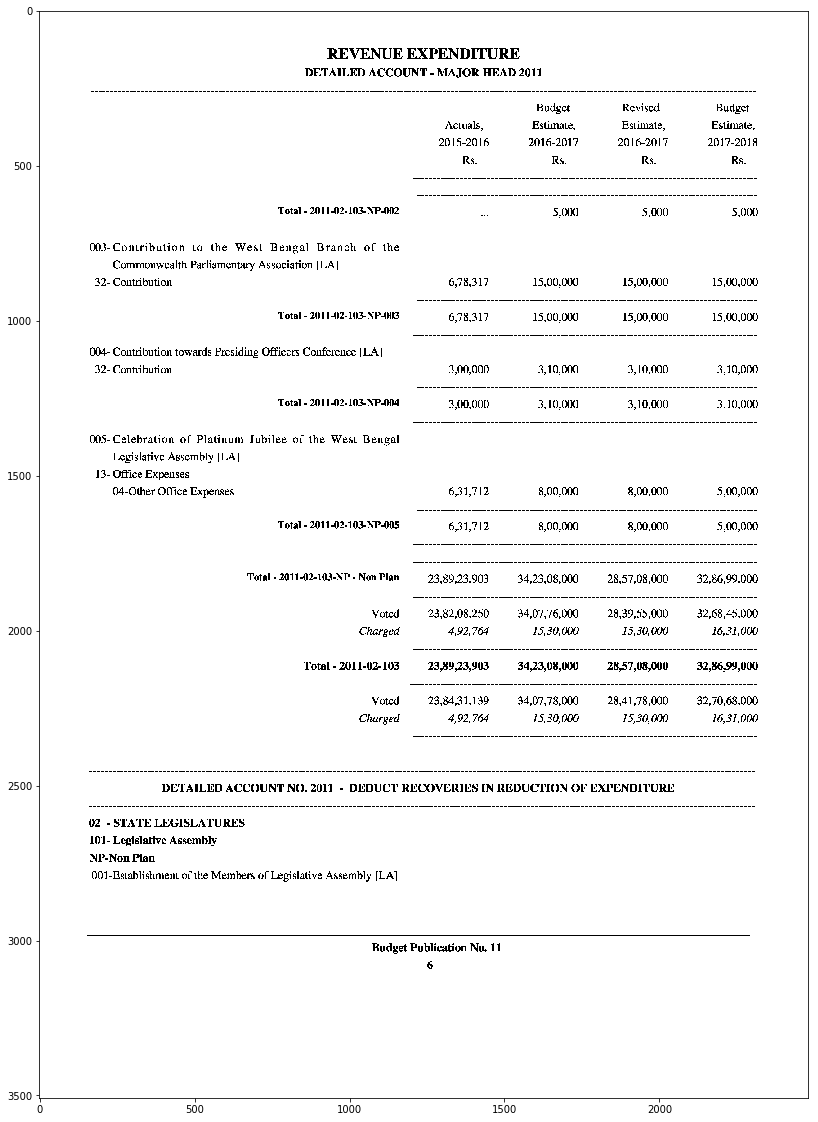

In [18]:
plot_page(img_page)

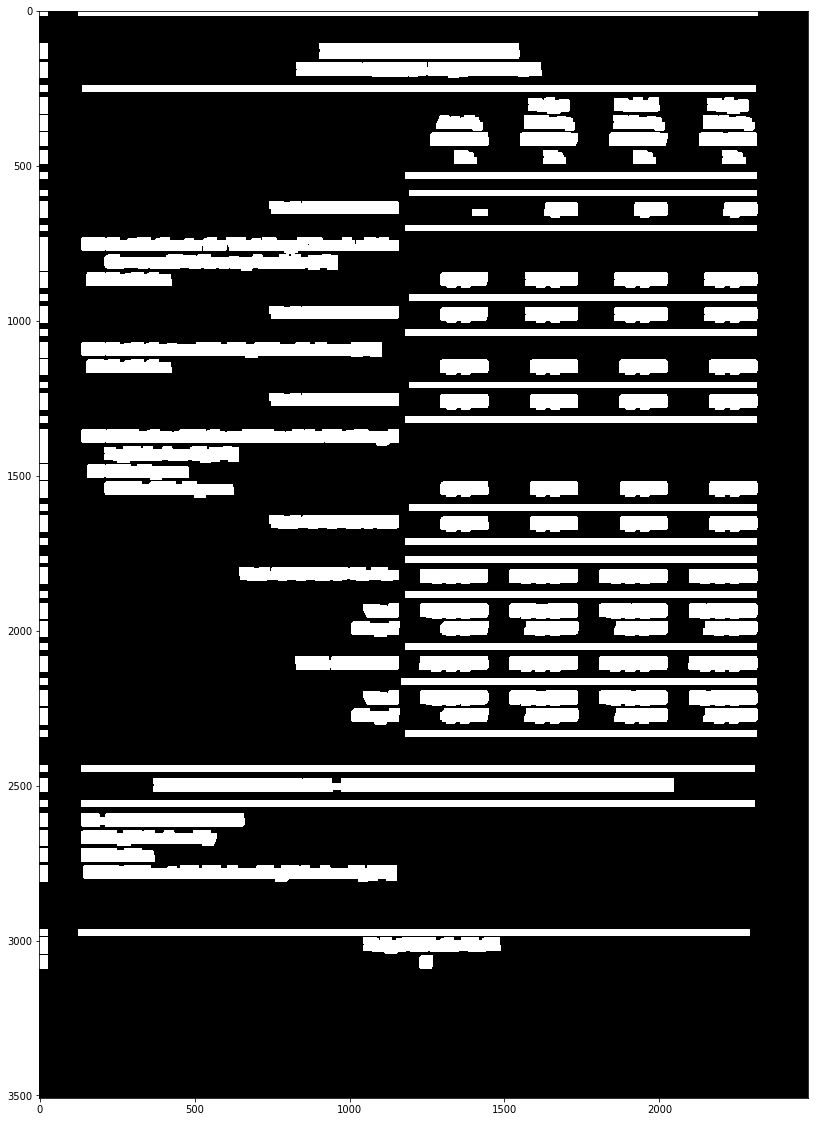

In [19]:
plot_page(feature_extractor.img_with_blocks)

In [159]:
block_features_with_labels[pd.isnull(block_features_with_labels.label)]

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,pos,possible_row_merger,right,table,text,text_length,top,width,row_index,col_index
14,6266.0,480.0,1355.320779,363.075168,0.0,142.0,1.0,None,1262.0,NaN,14.0,0.0,1450.0,1.0,"Actuals, 2015-2016 Rs",8.0,338.0,188.0,0.0,2.0
31,10297.0,609.0,251.283675,586.701466,0.0,46.0,1.0,None,136.0,NaN,31.0,0.0,612.0,1.0,002- S c h e m efor Export,16.0,563.0,476.0,2.0,0.0
33,8913.0,609.0,723.344329,587.726804,0.0,46.0,1.0,None,615.0,NaN,33.0,0.0,902.0,1.0,t Promotionof,11.0,563.0,287.0,2.0,0.0
35,11068.0,617.0,1030.477864,587.942356,0.0,54.0,1.0,None,903.0,NaN,35.0,0.0,1162.0,1.0,f Agricultural,14.0,563.0,259.0,2.0,1.0
37,14986.0,670.0,397.576204,643.925797,0.0,51.0,1.0,None,211.0,NaN,37.0,0.0,565.0,1.0,commmodities- [AM],18.0,619.0,354.0,4.0,0.0
55,38028.0,955.0,557.720758,924.900415,0.0,54.0,1.0,None,136.0,NaN,55.0,0.0,979.0,1.0,003- Training of Marketing Officials and Other...,52.0,901.0,843.0,7.0,0.0
73,43662.0,1236.0,646.250882,1206.443063,0.0,54.0,1.0,None,136.0,NaN,73.0,0.0,1162.0,1.0,006- Scheme for Introduction of Pledge Finance...,54.0,1182.0,1026.0,10.0,0.0
75,25190.0,1292.0,493.211314,1262.190274,0.0,54.0,1.0,None,210.0,NaN,75.0,0.0,776.0,1.0,Regulated Market Committee [AM],31.0,1238.0,566.0,11.0,0.0
93,45536.0,1573.0,643.852688,1543.073305,0.0,54.0,1.0,None,136.0,NaN,93.0,0.0,1162.0,1.0,"008- Agricultural Marketing Information ,Publi...",65.0,1519.0,1026.0,14.0,0.0
95,21063.0,1630.0,457.897593,1601.317856,0.0,54.0,1.0,None,210.0,NaN,95.0,0.0,692.0,1.0,farm produce marketing [AM],27.0,1576.0,482.0,15.0,0.0


In [38]:
labeler = BlockLabeler(block_features)

In [39]:
BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
                                                                           combine_headers,
                                                                           combine_horizontal]).label()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:20]


,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,pos,possible_row_merger,right,table,text,text_length,top,width
4,34242.0,159.0,1225.832545,131.135126,0.0,54.0,1.0,title,904.0,NaN,4.0,0.0,1549.0,1.0,REVENUE EXPENDITURE,19.0,105.0,645.0
6,35759.0,218.0,1226.409128,191.237646,0.0,49.0,1.0,title,831.0,NaN,6.0,0.0,1622.0,1.0,DETAILED ACCOUNT - MAJOR HEAD 2435,34.0,169.0,791.0
10,6063.0,478.0,1643.703777,307.102260,0.0,196.0,1.0,header,1552.0,NaN,10.0,0.0,1738.0,1.0,"Budget Estimate, 2016-2017 Rs",6.0,282.0,186.0
11,6304.0,470.0,1926.597874,305.548382,0.0,188.0,1.0,header,1841.0,NaN,11.0,0.0,2027.0,1.0,"Revised Estimate, 2016-2017 Rs",7.0,282.0,186.0
12,6063.0,478.0,2221.703777,307.102260,0.0,196.0,1.0,header,2130.0,NaN,12.0,0.0,2316.0,1.0,"Budget Estimate, 2017-2018 Rs",6.0,282.0,186.0
14,6138.0,480.0,1356.294233,363.163734,0.0,142.0,1.0,header,1264.0,NaN,14.0,0.0,1450.0,1.0,"Actuals, 2015-2016 Rs",8.0,338.0,186.0
33,21590.0,665.0,892.857388,643.035433,0.0,46.0,1.0,grouping,636.0,NaN,33.0,0.0,1162.0,1.0,Total - 101 - Deduct - Recoveries,33.0,619.0,526.0
34,6214.0,670.0,1382.307692,642.358545,1.0,51.0,0.0,number_values,1310.0,-30370.0,34.0,0.0,1450.0,1.0,"-30,370",7.0,619.0,140.0
35,7574.0,670.0,1657.645102,642.666887,1.0,51.0,0.0,number_values,1571.0,-135000.0,35.0,0.0,1739.0,1.0,"-1,35,000",9.0,619.0,168.0
36,6220.0,670.0,1960.333923,642.336013,1.0,51.0,0.0,number_values,1888.0,-30000.0,36.0,0.0,2028.0,1.0,"-30,000",7.0,619.0,140.0


In [40]:
block_features.head()

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,left,number,pos,possible_row_merger,right,text,text_length,top,width,label
4,34242.0,159.0,1225.832545,131.135126,0.0,54.0,1.0,904.0,NaN,4.0,0.0,1549.0,REVENUE EXPENDITURE,19.0,105.0,645.0,None
6,35759.0,218.0,1226.409128,191.237646,0.0,49.0,1.0,831.0,NaN,6.0,0.0,1622.0,DETAILED ACCOUNT - MAJOR HEAD 2435,34.0,169.0,791.0,None
10,6063.0,336.0,1643.703777,307.102260,0.0,54.0,1.0,1577.0,NaN,10.0,0.0,1712.0,Budget,6.0,282.0,135.0,None
11,6304.0,328.0,1926.597874,305.548382,0.0,46.0,1.0,1854.0,NaN,11.0,0.0,2001.0,Revised,7.0,282.0,147.0,None
12,6063.0,336.0,2221.703777,307.102260,0.0,54.0,1.0,2155.0,NaN,12.0,0.0,2290.0,Budget,6.0,282.0,135.0,None


In [41]:
table_2 = block_features_with_labels[block_features_with_labels.table == 2]
table_headers = table_2[table_2.label == 'header']
table_headers['top_zscore'] = (table_headers.top - table_headers.top.mean()) / table_headers.top.std(ddof=0)

In [42]:
table_headers[table_headers.top_zscore > 1]['pos'].values.flatten()

array([], dtype=float64)

In [43]:
text_with_no_labels = block_features_with_labels[pd.isnull(block_features_with_labels.label)]
text_with_no_labels['text_to_be_merged'] = text_with_no_labels['text'].apply(lambda x: not (x[0].isupper() or x[0].isdigit()))
text_with_no_labels

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:2]


,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,...,possible_row_merger,right,table,text,text_length,top,width,row_index,col_index,text_to_be_merged
14,6138.0,480.0,1356.294233,363.163734,0.0,142.0,1.0,None,1264.0,NaN,...,0.0,1450.0,1.0,"Actuals, 2015-2016 Rs",8.0,338.0,186.0,0.0,1.0,False
41,32135.0,785.0,495.789793,756.092143,0.0,53.0,1.0,None,137.0,NaN,...,0.0,860.0,1.0,102- Grading and Quality Control Facilities,43.0,732.0,723.0,3.0,0.0,False
43,10208.0,834.0,251.318966,811.216693,0.0,46.0,1.0,None,137.0,NaN,...,0.0,374.0,1.0,NP-Non Plan,11.0,788.0,237.0,4.0,0.0,False
45,38178.0,898.0,568.452198,868.439127,0.0,54.0,1.0,None,144.0,NaN,...,0.0,988.0,1.0,001-Agricultural Marketing and Quality Control...,51.0,844.0,844.0,5.0,0.0,False
47,14989.0,947.0,336.862633,924.993662,0.0,46.0,1.0,None,162.0,NaN,...,0.0,520.0,1.0,70-Deduct Recoveries,20.0,901.0,358.0,6.0,0.0,False
71,40477.0,1291.0,603.678484,1261.831830,0.0,53.0,1.0,None,137.0,NaN,...,0.0,1070.0,1.0,190- Assistance to Public Sector and Other Und...,55.0,1238.0,933.0,12.0,0.0,False
73,31391.0,1346.0,493.676277,1317.455704,0.0,52.0,1.0,None,138.0,NaN,...,0.0,848.0,1.0,SP-State Plan (Annual Plan & XII th Plan),41.0,1294.0,710.0,13.0,0.0,False
75,28960.0,1405.0,464.083633,1374.709289,0.0,54.0,1.0,None,144.0,NaN,...,0.0,786.0,1.0,002-Subsidy to Bullock Cart Users [AM],38.0,1351.0,642.0,14.0,0.0,False
77,14989.0,1453.0,336.862633,1430.993662,0.0,46.0,1.0,None,162.0,NaN,...,0.0,520.0,1.0,70-Deduct Recoveries,20.0,1407.0,358.0,15.0,0.0,False
95,20192.0,1734.0,363.690670,1711.102466,0.0,46.0,1.0,None,135.0,NaN,...,0.0,600.0,1.0,796- Tribal Areas Sub-Plan,26.0,1688.0,465.0,18.0,0.0,False


In [30]:
block_features_with_labels[block_features_with_labels.table == 1].col_index.unique()

array([ 0.,  2.,  3.,  4.,  1.])

In [35]:
table_rows = block_features_with_labels[block_features_with_labels.table == 1]
col_per_row = table_rows.groupby('row_index')['pos'].count()
table_rows[table_rows.row_index.isin(col_per_row[col_per_row == col_per_row.max()].index.tolist())].right.unique()

array([ 1161.,  1450.,  1739.,  2028.,  2317.,   586.,  1449.,   454.,
         470.,   896.,  1162.,   443.,  1738.,  2026.,  2315.,   445.,
         907.,   628.,  1163.])

TODO: 

     - Text joining - Lower text check fails at some points, needs to be re thought.
     - Column split
     - Fixed Headers (Budget Head, Particulars, Voted/charged) https://openbudgetsindia.org/dataset/karnataka-volume-3-2202-general-education-2014-15/resource/bdee262e-1739-4d83-be5c-7618442b22a5 - done
     - Budget Head Extraction - done
     - Move Total into the second column - done
     - Add Logging
     - Adaptive threshold

-----
## Glossary

#### RLSA
The Run Length Smoothing Algorithm (RLSA) is a method that can be used for Block segmentation and text discrimination. The method developed for the Document Analysis System consists of two steps. First, a segmentation procedure subdivides the area of a document into regions (blocks), each of which should contain only one type of data (text, graphic, halftone image, etc.). Next, some basic features of these blocks are calculated.

The basic RLSA is applied to a binary sequence in which white pixels are represented by 0’s and black pixels by 1’s. The algorithm transforms a binary sequence x into an output sequence y according to the following rules:

    0’s in x are changed to 1’s in y if the number of adjacent 0’s is less than or equal to a predefined limit C.
    1’s in x are unchanged in y .

For example, with C = 4 the sequence x is mapped into y as follows:

    x : 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
    y : 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1